In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [46]:
NUM_CLASSES = 25

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [23]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_9 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                1720      
_________________________________________________________________
dropout_10 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 40)                1640      
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)                820       
_________________________________________________________________
dropout_12 (Dropout)         (None, 20)               

In [48]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [49]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [50]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
126/126 [==============================] - 1s 3ms/step - loss: 3.1250 - accuracy: 0.0705 - val_loss: 2.8294 - val_accuracy: 0.1271

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/1000
126/126 [==============================] - 0s 1ms/step - loss: 2.8091 - accuracy: 0.1217 - val_loss: 2.4459 - val_accuracy: 0.2528

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/1000
126/126 [==============================] - 0s 1ms/step - loss: 2.4839 - accuracy: 0.2005 - val_loss: 2.0092 - val_accuracy: 0.3437

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/1000
126/126 [==============================] - 0s 1ms/step - loss: 2.1677 - accuracy: 0.2688 - val_loss: 1.7088 - val_accuracy: 0.4374

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/1000
126/126 [==============================] - 0s 1ms/step - loss: 1.9909 - accuracy: 0.307

In [51]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

42/42 [==============================] - 0s 584us/step - loss: 0.3364 - accuracy: 0.9219


In [52]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [53]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[8.6993623e-10 9.0488922e-21 7.0428428e-08 0.0000000e+00 1.8215870e-33
 1.0152000e-20 0.0000000e+00 1.2083237e-09 7.2714403e-19 9.9627340e-01
 9.0536801e-31 0.0000000e+00 1.2981079e-14 0.0000000e+00 3.7263534e-03
 3.0299277e-11 3.3824401e-17 0.0000000e+00 8.6162102e-23 1.1553206e-11
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.7546781e-08 2.9989353e-09]
9


# Confusion matrix

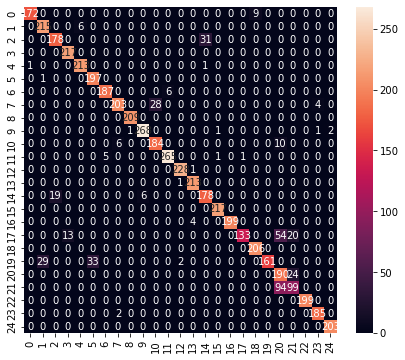

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       181
           1       0.88      0.97      0.92       221
           2       0.90      0.85      0.88       209
           3       0.94      1.00      0.97       217
           4       0.97      0.99      0.98       215
           5       0.86      0.99      0.92       198
           6       0.97      0.97      0.97       193
           7       0.96      0.86      0.91       235
           8       1.00      1.00      1.00       209
           9       0.98      0.98      0.98       273
          10       0.87      0.92      0.89       200
          11       0.98      0.97      0.98       272
          12       0.99      1.00      0.99       229
          13       0.98      1.00      0.99       214
          14       0.85      0.88      0.86       203
          15       0.99      1.00      1.00       217
          16       1.00      0.98      0.99       203
     

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [55]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [56]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Lucas\AppData\Local\Temp\tmplj9jo9fp\assets


9536

# Inference test

In [57]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [58]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [59]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [60]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 2 ms


In [61]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.47150136e-10 6.45271115e-21 3.41384023e-08 0.00000000e+00
 8.21749530e-34 7.08262010e-21 0.00000000e+00 1.29546029e-09
 3.57029195e-19 9.97475564e-01 1.17748545e-30 0.00000000e+00
 1.11935116e-14 0.00000000e+00 2.52422923e-03 1.69578292e-11
 2.61045033e-17 0.00000000e+00 1.13955300e-22 1.27480570e-11
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.95655745e-08
 4.45458337e-09]
9
